# Recommendation Systems
A reccomendation system is designed to asnwer the question: "Given a user, what should we show them next?” It focuses on personalisation and learning user-item interactions. The input of a reccomendation system is a user and their associated data and the output is a a ranked list of recommended items personalized to that user.

---

### Popularity Based Filtering
 Popularity Based reccomendations are high level reccomendations you might see when you first sign up to a service if the service provider has no additional information about you, your likes or your demographic.

**Implementation:**
- **All time top rated:** The all time top rated movies as scored by the IMDB formula (baysian average)
- **Currently trending:** This shows the top rated movies for the most recent time period. In this case I use reviews from 2016 to find the currently trending movies, again as scored by the IMBD formula.

---

### Demographic Filtering:
Demographic Filtering recommends items based on user demographic attributes such as age, gender, location, income, etc.

**Example**: recommending romantic comedies to young women based on general trends.

*This dataset does not contain demographic data, so this method hasn't been implemented but it's important to know.

---

### Content Based Filtering:
Content Based Filtering recommends items similar to those the user liked in the past, based on item features.

**Example**: Content-based filtering is because you watched Interstellar, which is directed by Christopher Nolan and marked as the genre Sci-Fi. We recommend Inception, which is also directed by Christopher Nolan and marked as the genre Sci-Fi

**Implementation:**
- Movie descriptions using a `TF-IDF vectorizer`.
- Categorical data transformed into a word soup, then vectorized using a `CountVectorizer`.
- A combined content-based filter that uses both features and both vectorizers and has capability to adjust their respective weightings.

---

### Collaborative Filtering:
Collaborative Filtering recommends items based on what similar users liked.

* **User-Based CF** recommends items to a user by identifying other users with similar taste and suggesting items those users liked.

  Example: *User A likes movies X, Y, and Z. User B has similar tastes and also liked movies X and Y, plus movie W. Because User A and User B have similar preferences, the system recommends movie W to User A.*

* **Item-Based CF** recommends items by finding similar items to those the user has liked — based on other users' co-preference patterns.

  Example: *User A liked Movie X. Movie Y is similar to Movie X because many users who liked X also liked Y. So, the system recommends Movie Y to User A.*

* **SVD Content based filtering** reccomends items based on a latent theme that is discovered by the SVD.

  Example: *User A has rated several movies highly that share certain hidden themes — for example, a mix of action and drama — which aren’t explicitly labeled but are inferred from rating patterns across many users. Movie X also strongly exhibits these hidden themes based on similar user ratings. Because User A and Movie X align on these latent factors discovered by the model, SVD predicts that User A will probably like Movie X.*

**Implementation**:
- The dataset was first filtered to reduce memory usage for model training.
- Ratings data was split into training and test sets, an SVD model was trained to learn latent user and movie factors, and its predictions on the test set achieved RMSE of 0.7483 and MAE of 0.5696.
- For user 24, I reviewed their liked movies to select test cases and examined predicted ratings on unseen movies:  
  - *Batman Begins*, which I expected they would like, received a relatively high predicted rating (3.7).  
  - *The Wedding Planner*, which I expected they would not like, received a lower predicted rating (3.3).  
- These results show the model effectively captures user preferences through collaborative filtering of latent features.



# Imports

In [1]:
# Upgrade numpy first to avoid binary incompatibility
!pip install numpy==1.26.4

#This will take a minute to compile because it has some Cython code.
!pip install scikit-surprise

In [2]:
import kagglehub
import os
import pandas as pd
import numpy as np
import requests
import re
from ast import literal_eval
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise.model_selection import train_test_split
from surprise import accuracy
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

## The Movies Dataset
**Movie data**
- `movies_metadata.csv`: The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.

- `keywords.csv`: Contains the movie plot keywords for our MovieLens movies. Available in the form of a stringified JSON Object.

- `credits.csv`: Consists of Cast and Crew Information for all our movies. Available in the form of a stringified JSON Object.

**Links**
- `links.csv`: The file that contains the TMDB and IMDB IDs of all the movies featured in the Full MovieLens dataset.

- `links_small.csv`: Contains the TMDB and IMDB IDs of a small subset of 9,000 movies of the Full Dataset.

**Ratings**
- `ratings.csv`: Each line of this file after the header row represents one rating of one movie by one user. Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

- `ratings_small.csv`: The subset of 100,000 ratings from 700 users on 9,000 movies.

In [3]:
path = kagglehub.dataset_download("rounakbanik/the-movies-dataset")
print(path)
os.listdir(path)

/kaggle/input/the-movies-dataset


['ratings.csv',
 'links_small.csv',
 'credits.csv',
 'keywords.csv',
 'movies_metadata.csv',
 'ratings_small.csv',
 'links.csv']

#### Keywords & Credits

In [4]:
keywords_df = pd.read_csv(path + '/keywords.csv')
display(keywords_df.head(3))

credits_df = pd.read_csv(path + '/credits.csv')
display(credits_df.head(3))

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."


,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602


#### Ratings

In [5]:
ratings_df = pd.read_csv(path + '/ratings.csv')

# Format timestamp column
# Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.
ratings_df['timestamp_readable'] = pd.to_datetime(ratings_df['timestamp'], unit='s', utc=True)
ratings_df['timestamp_readable'] = ratings_df['timestamp_readable'].dt.tz_localize(None)

ratings_df.head(3)

,userId,movieId,rating,timestamp,timestamp_readable
0,1,110,1.0,1425941529,2015-03-09 22:52:09
1,1,147,4.5,1425942435,2015-03-09 23:07:15
2,1,858,5.0,1425941523,2015-03-09 22:52:03


#### Movie metadata

In [6]:
metadata_df = pd.read_csv(path + '/movies_metadata.csv')
metadata_df['poster_path'] = 'https://image.tmdb.org/t/p/original' + metadata_df['poster_path']

<ipython-input-6-923dbcc80715>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv(path + '/movies_metadata.csv')


# Pre-processing

In [7]:
print('rows before cleaning:', len(metadata_df))

# remove rows with corrupted id and convert id to int for merging
metadata_df = metadata_df[pd.to_numeric(metadata_df['id'], errors='coerce').notna()].copy()
metadata_df['id'] = metadata_df['id'].astype(int)

# Removes rows with duplicate 'title' values, keeping only the row with the highest 'vote_count'.
metadata_df = metadata_df.sort_values(by='vote_count', ascending=False)
metadata_df = metadata_df.drop_duplicates(subset='title', keep='first')

# filtering to prevent RAM issues
metadata_df = metadata_df[metadata_df['original_language'] == 'en']
metadata_df = metadata_df[metadata_df['status'] == 'Released']
metadata_df = metadata_df[metadata_df['adult'] == 'False']
lower_runtime = metadata_df['runtime'].quantile(.1)
metadata_df = metadata_df[(metadata_df['runtime'] >= lower_runtime)]

print('rows after cleaning:', len(metadata_df))
print('shortest runtime:', lower_runtime, 'mins')
metadata_df.head(3)

rows before cleaning: 45466
rows after cleaning: 26759
shortest runtime: 66.0 mins


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
15480,False,NaN,160000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",http://inceptionmovie.warnerbros.com/,27205,tt1375666,en,Inception,"Cobb, a skilled thief who commits corporate es...",...,2010-07-14,8.255328e+08,148.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Your mind is the scene of the crime.,Inception,False,8.1,14075.0
12481,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,155,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,...,2008-07-16,1.004558e+09,152.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Why So Serious?,The Dark Knight,False,8.3,12269.0
14551,False,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,tt0499549,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",...,2009-12-10,2.787965e+09,162.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,False,7.2,12114.0


In [8]:
# Merge metadata with credits and keywords
metadata_df = metadata_df.merge(credits_df, on='id').merge(keywords_df, on='id')
metadata_df.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,NaN,160000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",http://inceptionmovie.warnerbros.com/,27205,tt1375666,en,Inception,"Cobb, a skilled thief who commits corporate es...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Your mind is the scene of the crime.,Inception,False,8.1,14075.0,"[{'cast_id': 1, 'character': 'Dom Cobb', 'cred...","[{'credit_id': '56e8462cc3a368408400354c', 'de...","[{'id': 1014, 'name': 'loss of lover'}, {'id':..."
1,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,155,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Why So Serious?,The Dark Knight,False,8.3,12269.0,"[{'cast_id': 35, 'character': 'Bruce Wayne / B...","[{'credit_id': '55a0eb4a925141296b0010f8', 'de...","[{'id': 849, 'name': 'dc comics'}, {'id': 853,..."
2,False,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995,tt0499549,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,False,7.2,12114.0,"[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...","[{'id': 1463, 'name': 'culture clash'}, {'id':..."


In [9]:
# Parse the stringified features into their corresponding python objects
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    metadata_df[feature] = metadata_df[feature].apply(literal_eval)

In [10]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

# Define new director, cast, genres and keywords features that are in a suitable form.
metadata_df['director'] = metadata_df['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    metadata_df[feature] = metadata_df[feature].apply(get_list)

metadata_df.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords,director
0,False,NaN,160000000,"[Action, Thriller, Science Fiction]",http://inceptionmovie.warnerbros.com/,27205,tt1375666,en,Inception,"Cobb, a skilled thief who commits corporate es...",...,Released,Your mind is the scene of the crime.,Inception,False,8.1,14075.0,"[Leonardo DiCaprio, Joseph Gordon-Levitt, Elle...","[{'credit_id': '56e8462cc3a368408400354c', 'de...","[loss of lover, dream, kidnapping]",Christopher Nolan
1,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[Drama, Action, Crime]",http://thedarkknight.warnerbros.com/dvdsite/,155,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,...,Released,Why So Serious?,The Dark Knight,False,8.3,12269.0,"[Christian Bale, Michael Caine, Heath Ledger]","[{'credit_id': '55a0eb4a925141296b0010f8', 'de...","[dc comics, crime fighter, secret identity]",Christopher Nolan
2,False,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000,"[Action, Adventure, Fantasy]",http://www.avatarmovie.com/,19995,tt0499549,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",...,Released,Enter the World of Pandora.,Avatar,False,7.2,12114.0,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]","[{'credit_id': '52fe48009251416c750aca23', 'de...","[culture clash, future, space war]",James Cameron


# Popularity based filtering

This dataset does not contain demographic data so instead I will make a couple of simple popularity based reccomendations.

Popularity-based recommender systems suggest items that are most popular among all users, typically based on metrics like view counts, purchases, or ratings. These systems are simple, scalable, and effective in scenarios where user-specific data is limited or cold-start problems exist.

## All-Time Top Rated

IMDB Formula (Bayesian Average) is the classic approach IMDB uses to rank movies:

`WR = (v / (v + m)) * R + (m / (v + m)) * C`

Where:
- `WR` = weighted rating
- `R` = average rating for the item
- `v` = number of votes for the item
- `m` = minimum votes required to be considered (threshold)
- `C` = the mean vote across the whole dataset

### Finding threshold value

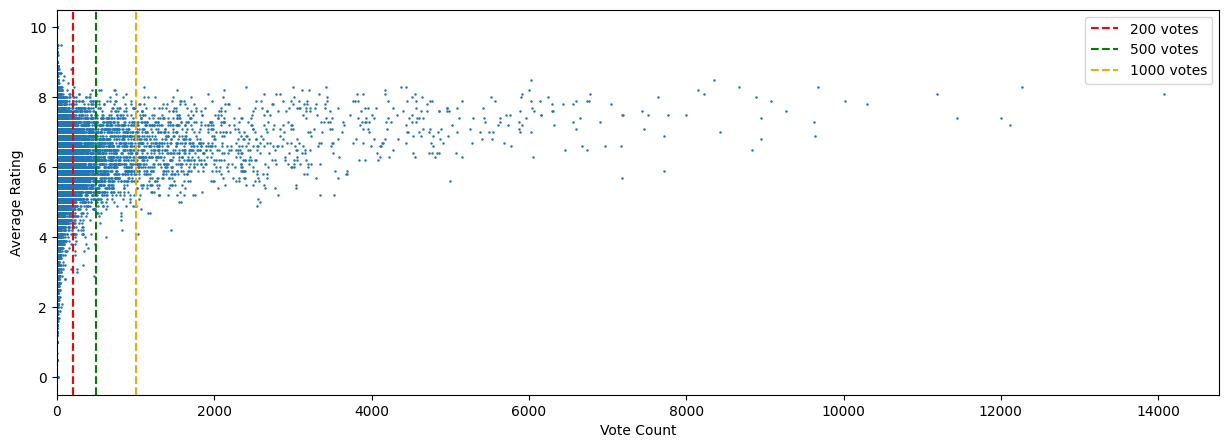

In [11]:
plt.figure(figsize=(15, 5))

plt.scatter(x=metadata_df['vote_count'], y=metadata_df['vote_average'], s=0.6)

plt.axvline(200, color='red', linestyle='--', label=f'200 votes')
plt.axvline(500, color='green', linestyle='--', label=f'500 votes')
plt.axvline(1000, color='orange', linestyle='--', label=f'1000 votes')

# Adjust graph
plt.xlabel('Vote Count')
plt.ylabel('Average Rating')
plt.xlim(left=0)
plt.legend()

plt.show()

I chose my threshold as 200 as after this point the highest ratings seem to level out. I have removed one outlier that can be seen clearly in the scatter plot.

In [12]:
votes_200_df = metadata_df[metadata_df['vote_count']>200].sort_values('vote_average', ascending=False)[['title', 'vote_average', 'vote_count', 'poster_path']]

# show updated dataframe
votes_200_df.head(3)

,title,vote_average,vote_count,poster_path
61,The Godfather,8.5,6024.0,https://image.tmdb.org/t/p/original/rPdtLWNsZm...
19,The Shawshank Redemption,8.5,8358.0,https://image.tmdb.org/t/p/original/9O7gLzmreU...
1,The Dark Knight,8.3,12269.0,https://image.tmdb.org/t/p/original/1hRoyzDtpg...


In [13]:
def weighted_rating(row, m, C, vote_count_col, vote_avg_col):
  """
  A function to calculcate the IMDB rating for a single movie Series

  m (int) - minimum votes required to be considered (threshold)
  C (int) - the mean vote across the whole dataset
  vote_count_col (str) - name of column containting number of ratings for that movie
  vote_avg_col (str)- name of column containting average rating for that movie
  """
  v = row[vote_count_col]
  R = row[vote_avg_col]
  # Calculation based on the IMDB formula
  return (v/(v+m) * R) + (m/(m+v) * C)

# Define a new feature 'score' and calculate its value with `weighted_rating()`
votes_200_df['imbd_score'] = votes_200_df.apply(weighted_rating,
                                                m=200,
                                                C=votes_200_df['vote_average'].mean(),
                                                vote_count_col = 'vote_count',
                                                vote_avg_col = 'vote_average',
                                                axis=1)

votes_200_df.sort_values('imbd_score', ascending=False)

top_20_movies = votes_200_df[:20].copy()
top_20_movies.head(7)

,title,vote_average,vote_count,poster_path,imbd_score
61,The Godfather,8.5,6024.0,https://image.tmdb.org/t/p/original/rPdtLWNsZm...,8.433331
19,The Shawshank Redemption,8.5,8358.0,https://image.tmdb.org/t/p/original/9O7gLzmreU...,8.451513
1,The Dark Knight,8.3,12269.0,https://image.tmdb.org/t/p/original/1hRoyzDtpg...,8.269929
149,Schindler's List,8.3,4436.0,https://image.tmdb.org/t/p/original/yPisjyLweC...,8.219122
394,Psycho,8.3,2405.0,https://image.tmdb.org/t/p/original/81d8oyEFgj...,8.156065
17,Pulp Fiction,8.3,8670.0,https://image.tmdb.org/t/p/original/dM2w364MSc...,8.257728
287,One Flew Over the Cuckoo's Nest,8.3,3001.0,https://image.tmdb.org/t/p/original/2Sns5oMb35...,8.182865


## Currently Trending

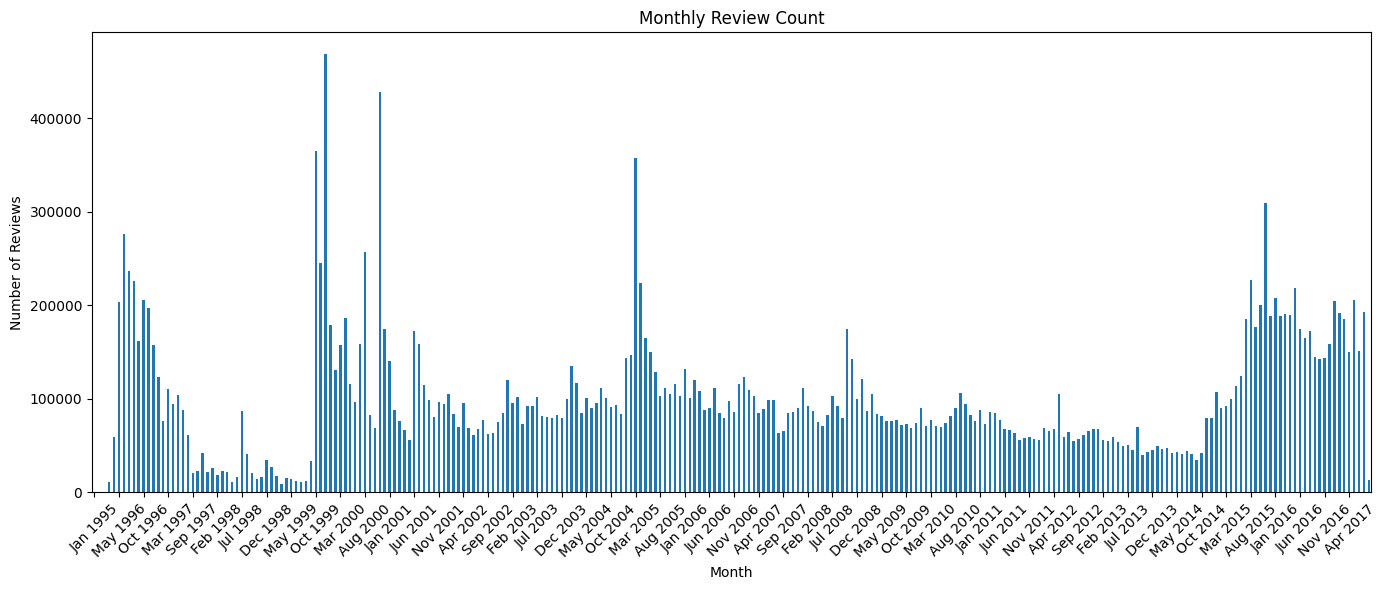

In [14]:
# Extract year and month, and count reviews per month
monthly_counts = ratings_df['timestamp_readable'].dt.to_period('M').value_counts().sort_index()

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
monthly_counts.plot(kind='bar', ax=ax)
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Monthly Review Count')

# Show every 3rd month only
xticks = list(range(0, len(monthly_counts), 5))
xtick_labels = [monthly_counts.index[i].strftime('%b %Y') for i in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=45)

plt.tight_layout()
plt.show()

Calculate IMBD ratings based only using reviews submitted in 2016. At scale this is likely to be ratings given in the last 30 days but I do not have sufficient data to acheive useful results with that timescale. However, the process would be the same.

In [15]:
#filter for reviews from 2016
df_2016 = ratings_df[ratings_df['timestamp_readable'].dt.year >= 2016]

# Get mean reviews and number of reviews for movies, only considering 2016 reviews
trending_df = df_2016.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index().sort_values('mean', ascending=True)

# filter for movies with more than 5 reviews in this period
trending_df = trending_df[trending_df['count'] >=50]

# Calculate IMBD rating based on only 2016 reviews
trending_df['imbd_score'] = trending_df.apply(weighted_rating,
                                                m=50, #  m - minimum votes required to be considered (threshold)
                                                C=df_2016['rating'].mean(), #C = the mean vote across the whole dataset
                                                vote_count_col = 'count',
                                                vote_avg_col = 'mean',
                                                axis=1)

trending_df = trending_df.rename(columns={'movieId':'id'})
trending_df.sort_values('imbd_score', ascending=False).head(4)

,id,mean,count,imbd_score
33511,159817,4.478780,754,4.420633
296,318,4.353308,14193,4.350466
1060,1203,4.287671,2263,4.271590
37477,170705,4.394366,284,4.267032


In [16]:
# merge with metadata to get movie titles, posters and release dates
trending_df = trending_df.merge(metadata_df[['poster_path', 'id', 'title', 'release_date']], on='id')
trending_df = trending_df.sort_values('imbd_score', ascending=False)

# Content Based Filtering
Content-based filtering recommends items by comparing the attributes of items a user has liked in the past with those of other items. It relies on item features (e.g., genre, keywords, or descriptions) and builds user profiles to make personalized suggestions without needing data from other users.

#### Content Based Filtering using descriptions
##### TF-IDF
Term Frequency-Inverse Document Frequency

**TF (Term Frequency):**

TF = (Number of times term `t` appears in document `d`) / (Total number of terms in document `d`)

- Measures how often a word appears in a specific document.
- A higher frequency suggests greater importance within that document.
- TF alone does not consider how common the term is across the entire corpus — that’s what IDF corrects for.

**IDF (Inverse Document Frequency):**

IDF = log(total number of documents in corpus D / number of documents containing term t)

- Reduces the weight of common words across multiple documents while increasing the weight of rare words.
- If a term appears in fewer documents, it is more likely to be meaningful and specific.
- The logarithm is used to dampen the effect of very large or very small values, ensuring the IDF score scales appropriately.

##### For example:
- Document 1: "The cat sat on the mat."
- Document 2: "The dog played in the park."
- Document 3: "Cats and dogs are great pets."

**TF:**
- For document 1, term=cat TF=1/5=0.2
- For document 1, term=the TF=2/5=0.4
- For document 1, term=park TF=0

**IDF:**
- term=cat, IDF=3/2 = 1.5
- term=the IDF=3/2 = 1.5
- term=park 3/1 = 3

**TF-IDF:**

| **Document** | **Cat** | **The** | **Park** |
|--------------|---------|---------|----------|
| 1 | 0.2 x log(1.5) | 0.4 x log(1.5) | 0 x log(3) |
| 2 | 0 x log(1.5) | 0.4 x log(1.5) | 0.2 x log(3) |


| **Document** | **Cat** | **The** | **Park** |
|--------------|---------|---------|----------|
| 1            | 0.0352  | 0.0704  | 0        |
| 2            | 0       | 0.0704  | 0.0954   |

##### Limitations
TF-IDF is limited in capturing semantic meaning because it treats words as isolated tokens and ignores context, word order, and relationships between words. As a result, it cannot recognize that synonyms like "car" and "automobile" are related, or that "not good" has an opposite sentiment to "good".

To overcome these limitations, we can use word embeddings such as Word2Vec, GloVe, or transformer-based models like BERT, which capture the contextual and semantic relationships between words and sentences by placing them in a dense vector space based on meaning.

In [17]:
def preprocess(text):
    text = text.lower()
    # replace fill text with empty string
    text = re.sub('no overview found', '', text.lower())
    # preserve only a-z characters and spaces
    text = re.sub(r'[^a-z\s]', '', text.lower())
    # remove double or tripple spaces
    text = re.sub(r'\s+', ' ', text)
    return text

In [18]:
metadata_df['overview'] = metadata_df['overview'].astype(str)
metadata_df['overview'] = metadata_df['overview'].apply(preprocess)

print(metadata_df['overview'])

0        cobb a skilled thief who commits corporate esp...
1        batman raises the stakes in his war on crime w...
2        in the nd century a paraplegic marine is dispa...
3        when an unexpected enemy emerges and threatens...
4        deadpool tells the origin story of former spec...
                               ...                        
27248    the year is the place is new port city the tan...
27249    new york times best seller and chelsea lately ...
27250    miles jupp star of rev and host of radio s the...
27251    thirtythree years ago an alien force known as ...
27252     years after decriminalisation of homosexualit...
Name: overview, Length: 27253, dtype: object


In [19]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

#Replace NaN with an empty string
metadata_df['overview'] = metadata_df['overview'].fillna('')
print('no movies:', len(metadata_df))

#Construct the required TF-IDF matrix by fitting and transforming the data
#Creates a matrix with a row for each movie, a column for each unique words after TF-IDF processing
# and the values represent TF-IDF scores, how important each word is in each overview
tfidf_matrix = tfidf.fit_transform(metadata_df['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

no movies: 27253


(27253, 653053)

In [20]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(metadata_df.index, index=metadata_df['title']).drop_duplicates()
indices

,0
title,
Inception,0
The Dark Knight,1
Avatar,2
The Avengers,3
Deadpool,4
...,...
New Dominion Tank Police,27248
Sarah Colonna: I Can't Feel My Legs,27249
Miles Jupp: Is The Chap You're Thinking Of,27250


In [21]:
title_description_dict = dict(zip(metadata_df['title'].str.lower(), metadata_df['overview']))

title_description_dict['deadpool']

'deadpool tells the origin story of former special forces operative turned mercenary wade wilson who after being subjected to a rogue experiment that leaves him with accelerated healing powers adopts the alter ego deadpool armed with his new abilities and a dark twisted sense of humor deadpool hunts down the man who nearly destroyed his life'

In [22]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, vectorizor=tfidf, matrix=tfidf_matrix, df=metadata_df, mapping_dict=title_description_dict):
    """
    title (str): Movie title
    vectorizor (array): Vectorizor (typically TfidfVectorizer)
    matrix (array): a matrix with a row for each movie, a column for each
      unique words after TF-IDF processing and the values represent TF-IDF scores

    Returns (df): Movie title of most similar movies
    """
    # Get the index of the movie that matches the title
    title = re.sub(r'[^a-z\s]', '', title.lower())

    # Try to find descrition for the given title
    try:
      description = mapping_dict[title]
    except:
      return None

    # Transform description into a vector
    query_vec = vectorizor.transform([description])
    # Compare single vector with tfidf matrix to get similarities
    # Doing this in the function means each call takes more time and may
    # eventually be duplicated effort but I do not have the ram to do the whole
    # computation in colab.
    similarities = cosine_similarity(query_vec, matrix)

    # Get indices from similarities
    movie_indices = similarities.argsort()[0][-10:-1] # Most similar index

    # Return DataFrame sorted from most relevant to least relevant
    return metadata_df['title'].iloc[np.flip(movie_indices)]

In [23]:
get_recommendations('eat, pray, love')

,title
5870,Make It Happen
18077,Country
25020,There's No Place Like Utopia
25021,There's No Place Like Utopia
10978,Breaking Through
10979,Breaking Through
1358,What We Do in the Shadows
1153,What's Eating Gilbert Grape
25461,Catatan (Harian) Si Boy


In [24]:
get_recommendations('the dark knight rises')

,title
1,The Dark Knight
700,Batman Forever
455,Batman
603,Batman Returns
2051,Batman: Under the Red Hood
4101,Batman Beyond: Return of the Joker
2229,"Batman: The Dark Knight Returns, Part 1"
26839,Three Cheers for the Irish
2172,"Batman: The Dark Knight Returns, Part 2"


### Content based filtering using Credits, Genres & Keywords

Content-based filtering using Credits, Genres, and Keywords involves creating a combined text “soup” for each movie by merging these categorical features into one string. For example, a movie with the genre Comedy, directed by Director X, and keywords like funny and light-hearted would have a soup like:
"Comedy DirectorX funny light-hearted"

I used CountVectorizer rather than TF-IDF because the repeated presence of a word like Comedy across many movies does not reduce its importance as a meaningful feature.


In [25]:
# Print the new features of the first 3 films
metadata_df[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Inception,"[Leonardo DiCaprio, Joseph Gordon-Levitt, Elle...",Christopher Nolan,"[loss of lover, dream, kidnapping]","[Action, Thriller, Science Fiction]"
1,The Dark Knight,"[Christian Bale, Michael Caine, Heath Ledger]",Christopher Nolan,"[dc comics, crime fighter, secret identity]","[Drama, Action, Crime]"
2,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"


In [26]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        # stripping spaces so the vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    metadata_df[feature] = metadata_df[feature].apply(clean_data)

In [27]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])

metadata_df['soup'] = metadata_df.apply(create_soup, axis=1)

In [28]:
metadata_df[['title', 'soup']].head(3)

,title,soup
0,Inception,lossoflover dream kidnapping leonardodicaprio ...
1,The Dark Knight,dccomics crimefighter secretidentity christian...
2,Avatar,cultureclash future spacewar samworthington zo...


In [29]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metadata_df['soup'])

In [30]:
title_soup_dict = dict(zip(metadata_df['title'].str.lower(), metadata_df['soup']))
get_recommendations('the dark knight rises', vectorizor=count, matrix=count_matrix, df=metadata_df, mapping_dict=title_soup_dict)

,title
1,The Dark Knight
27,Batman Begins
15209,Shiner
21321,Amongst Friends
12852,Mitchell
15079,Quicksand
8378,Romeo Is Bleeding
142,The Prestige
13849,Sara


In [31]:
get_recommendations('the godfather', vectorizor=count, matrix=count_matrix, df=metadata_df, mapping_dict=title_soup_dict)

,title
664,The Godfather: Part III
227,The Godfather: Part II
14914,The Rain People
26190,Last Exit
5228,The Son of No One
4681,The Good Neighbor
14947,The Night of the Following Day
12852,Mitchell
22128,Hide in Plain Sight


### Content based filtering using both descriptions and cateogrical features

When combining features from both TF-IDF and CountVectorizer, we use hstack to horizontally stack their sparse matrices. This means the columns from each matrix are placed side-by-side, creating a single wide matrix that contains all features from both vectorizers. Each row still represents the same movie, but now with combined information from both text-based (TF-IDF) and categorical (CountVectorizer) features. This allows the model to consider both types of data together when calculating similarities or building recommendations.

In [32]:
# Function that takes in movie title as input and outputs most similar movies
def get_reccomendations_2(title, alpha, beta):
    """
    title (str): Movie title
    vectorizor (array): Vectorizor (typically TfidfVectorizer)
    matrix (array): a matrix with a row for each movie, a column for each
      unique words after TF-IDF processing and the values represent TF-IDF scores

    Returns (df): Movie title of most similar movies
    """
    combined_matrix = hstack([tfidf_matrix * alpha,
                              count_matrix * beta])

    # Get the index of the movie that matches the title
    title = re.sub(r'[^a-z\s]', '', title.lower())

    # Try to find descrition for the given title
    try:
      description = title_description_dict[title]
      soup = title_soup_dict[title]
    except:
      return None

    # Vectorize new input using the fitted vectorizers
    description_vec = tfidf.transform([description])
    soup_vec = count.transform([soup])

    # Weight and stack new input
    query_vec = hstack([
        description_vec * alpha,
        soup_vec * beta
    ])

    similarities = cosine_similarity(query_vec, combined_matrix)

    # Get indices from similarities
    movie_indices = similarities.argsort()[0][-10:-1] # Most similar index

    # Return DataFrame sorted from most relevant to least relevant
    return metadata_df['title'].iloc[np.flip(movie_indices)]

In [33]:
content_based_results = {'Descriptions TF-IDF (1:0)' : get_reccomendations_2('the dark knight rises', 1, 0).reset_index(drop=True),
                          'Combined 1 (7:3)' : get_reccomendations_2('the dark knight rises', 0.7, 0.3).reset_index(drop=True),
                          'Combined 2 (3:7)' : get_reccomendations_2('the dark knight rises', 0.3, 0.7).reset_index(drop=True),
                          'Metadata CountVectorizer (0:1)' : get_reccomendations_2('the dark knight rises', 0, 1).reset_index(drop=True)}

pd.DataFrame(content_based_results)

,Descriptions TF-IDF (1:0),Combined 1 (7:3),Combined 2 (3:7),Metadata CountVectorizer (0:1)
0,The Dark Knight,The Dark Knight,The Dark Knight,The Dark Knight
1,Batman Forever,Batman Begins,Batman Begins,Batman Begins
2,Batman,Mitchell,Shiner,Shiner
3,Batman Returns,Shiner,Mitchell,Amongst Friends
4,Batman: Under the Red Hood,The Prestige,Amongst Friends,Mitchell
5,Batman Beyond: Return of the Joker,Quicksand,The Prestige,Quicksand
6,"Batman: The Dark Knight Returns, Part 1",Romeo Is Bleeding,Quicksand,Romeo Is Bleeding
7,Three Cheers for the Irish,Payback: Straight Up,Romeo Is Bleeding,The Prestige
8,"Batman: The Dark Knight Returns, Part 2",Batman Forever,Sara,Sara


The left column uses 100% descriptions (TF-IDF). The right column uses 100% metadata (CountVectorizer). The middle columns combine both, shifting the balance from more description to more metadata.

This helps visualize how changing these weights affects the recommendations.

# Collaborative Filtering

Collaborative Filtering (CF) is a technique used in recommender systems to predict a user's interests by collecting preferences from many users. The key idea is: “People who agreed in the past will agree again in the future.”

## There are two main types:

* **User-Based CF** recommends items to a user by identifying other users with similar taste and suggesting items those users liked.
  1. Calculate similarity between users using metrics like cosine similarity, Pearson correlation, etc.
  2. Select top-N similar users (a “neighborhood”).
  3. Aggregate their ratings/preferences for items the target user hasn’t seen.
  4. Recommend items with high average ratings among similar users.

* **Item-Based CF** recommends items by finding similar items to those the user has liked — based on other users' co-preference patterns.
  1. Compute item-item similarity based on how users rated them.
  2. For each item the user has liked, find similar items.
  3. Aggregate similarities to predict ratings for unseen items.
  4. Recommend the top-scoring items.

  Item-based CF: "People who watched Inception also watched Tenet
  
  Content-based Filtering: "You liked Inception, a sci-fi thriller, so here's Interstellar, another sci-fi thriller."


## SVD (Singular Value Decomposition)
Singular Value Decomposition tries to learn latent features that capture hidden patterns — like genre preferences or viewing habits, instead of trying to guess missing values directly.

SVD breaks the big user-movie matrix into:
* User matrix: Each user becomes a list of "hidden preferences" — like how much they like action, romance, plot twists, etc. (we don't name them, they’re just abstract "latent factors")
* Movie matrix: Each movie becomes a list of "hidden qualities" — like how action-packed, emotional, or complex it is.
* Weights matrix: A scaling matrix that tells us which of these hidden features matter most.

So instead of saying: *“User A rated Movie X a 4”*

We now say: *“User A likes action and drama, and Movie X is high in action and drama, so User A will probably like Movie X.”*

Once you’ve done the decomposition, you can multiply the matrices back together to get a completed version of the rating table. The missing ratings are now predicted values, based on shared patterns in the data.

Now for each user, you can look at the predicted ratings for movies they haven’t seen and recommend the ones with the highest predicted score.

In [34]:
# Filtering rows to prevent RAM overload
# This reduced RMSE from .90 to .75 but was necersary to run in google colab
print('Data points before filtering', len(ratings_df))

# Remove Infrequent Users
user_counts = ratings_df['userId'].value_counts()
filtered_users = user_counts[user_counts >= 500].index
ratings_df = ratings_df[ratings_df['userId'].isin(filtered_users)]


# Remove Infrequent Movies
movie_counts = ratings_df['movieId'].value_counts()
filtered_movies = movie_counts[movie_counts >= 500].index
ratings_df = ratings_df[ratings_df['movieId'].isin(filtered_movies)]

# Drop Duplicates
ratings_df.drop_duplicates(subset=['userId', 'movieId'], inplace=True)
ratings_df.dropna(inplace=True)

print('Data points before filtering', len(ratings_df))

Data points before filtering 26024289
Data points before filtering 7000669


In [35]:
%%time

# Create a Reader with appropriate rating scale
reader = Reader(rating_scale=(ratings_df['rating'].min(), ratings_df['rating'].max()))

# Load data into Surprise format
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Split into 80% train, 20% test
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Define and train the SVD model
svd = SVD(n_factors=15, n_epochs=10)
svd.fit(trainset)

# Predict on the test set
predictions = svd.test(testset)

# Evaluate with RMSE and MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.7510
MAE:  0.5715
RMSE: 0.7510
MAE: 0.5715
CPU times: user 1min 31s, sys: 2.31 s, total: 1min 33s
Wall time: 1min 35s


### Exploring Results for User 24

In [36]:
ratings_with_titles = ratings_df[['userId', 'movieId', 'rating']].merge(metadata_df[['id', 'title']], left_on='movieId', right_on='id')

print('Movies User 24 ranked 5.0')
ratings_with_titles[(ratings_with_titles['userId'] == 24) & (ratings_with_titles['rating'] == 5)]['title']

Movies User 24 ranked 5.0


,title
5,Pirates of the Caribbean: Dead Man's Chest
8,Scarface
16,The 39 Steps
19,Terminator 3: Rise of the Machines
20,The Million Dollar Hotel
27,Human Nature
31,Killing Zoe
34,Once Were Warriors
45,Men in Black II
46,Tomorrow Never Dies


#### Movie I would expect to have relatively high predicted ranking

In [37]:
# pick movie
movie = 'Batman Begins'

# check user hasn't already provided a rating
print('Existing User Rating:', bool(len(ratings_with_titles[(ratings_with_titles['userId'] == 24) & (ratings_with_titles['title'] == movie)])))

# get movie id
movie_id = metadata_df[metadata_df['title'] == movie]['id'].item()

# get prediction
print('\nPredicted Rating', svd.predict(24, movie_id, 3).est)

Existing User Rating: False

Predicted Rating 3.734632568171505


#### Movie I would expect to have relatively low predicted ranking

In [38]:
# pick movie
movie = 'The Wedding Planner'

# check user hasn't already provided a rating
print('Existing User Rating:', bool(len(ratings_with_titles[(ratings_with_titles['userId'] == 24) & (ratings_with_titles['title'] == movie)])))

# get movie id
movie_id = metadata_df[metadata_df['title'] == movie]['id'].item()

# get prediction
print('\nPredicted Rating', svd.predict(24, movie_id, 3).est)

Existing User Rating: False

Predicted Rating 3.35840969932404
